In [1]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
sns.set_style('whitegrid',{'axes.grid':False})

In [4]:
ldseq=np.array(os.listdir(dir_seg))

In [5]:
fnm=ldseq[0]

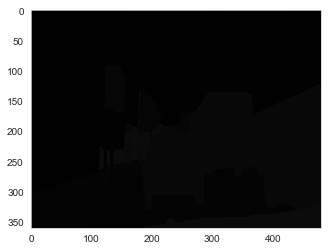

In [6]:
seg=cv2.imread(dir_seg+fnm)
plt.imshow(seg)
plt.show()

In [7]:
img_is=cv2.imread(dir_img+fnm)

In [8]:
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)


In [9]:
mi,ma=np.min(seg),np.max(seg)

In [10]:
n_classes=ma-mi+1
n_classes

12

In [11]:
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


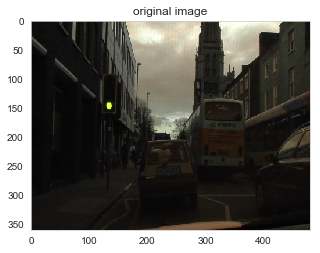

In [12]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title('original image')
plt.show()

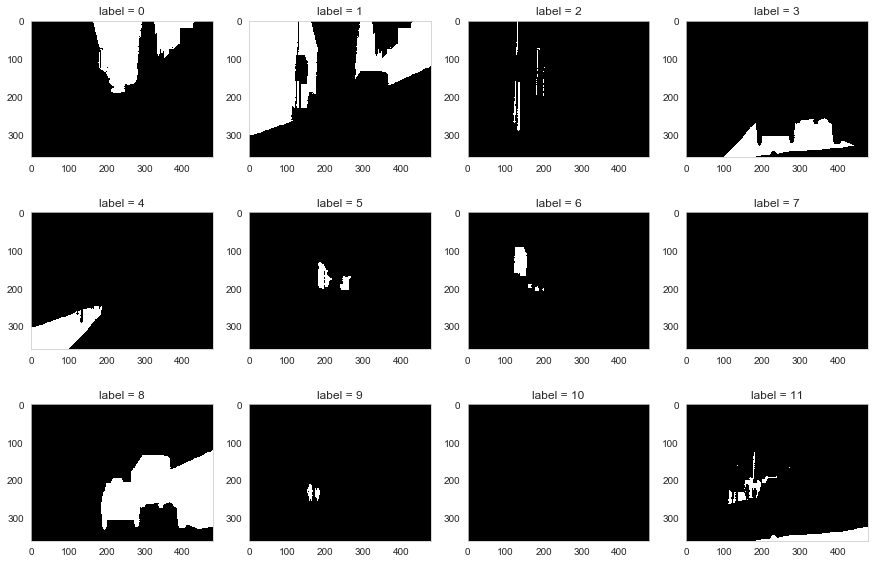

In [13]:
fig=plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax=fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg==k)*1.0)
    ax.set_title("label = {}".format(k))
plt.show()

In [14]:
import random

In [15]:
def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg=seg[:,:,0]
    seg_img=np.zeros((seg.shape[0],seg.shape[1],3)).astype('float')
    colors=sns.color_palette('hls',n_classes)
    
    for c in range(n_classes):
        segc=(seg==c)
        seg_img[:,:,0]+=(segc*(colors[c][0]))
        seg_img[:,:,1]+=(segc*(colors[c][1]))
        seg_img[:,:,2]+=(segc*(colors[c][2]))
    return(seg_img)

In [16]:
input_height,input_width=224,224
output_height,output_width=224,224

In [17]:
ldseg=np.array(os.listdir(dir_seg))

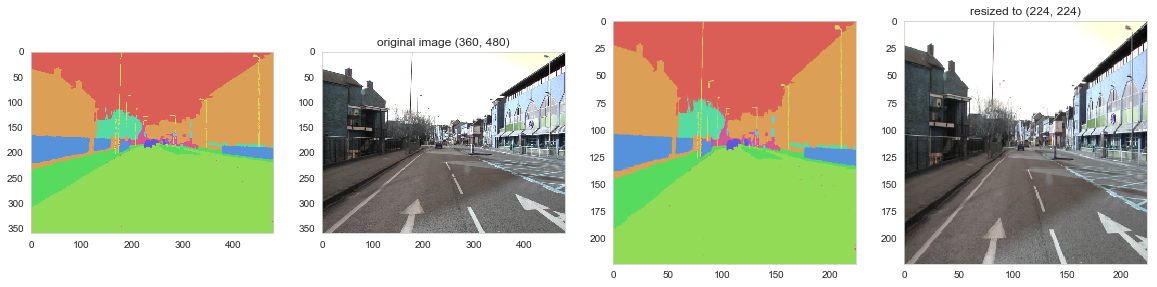

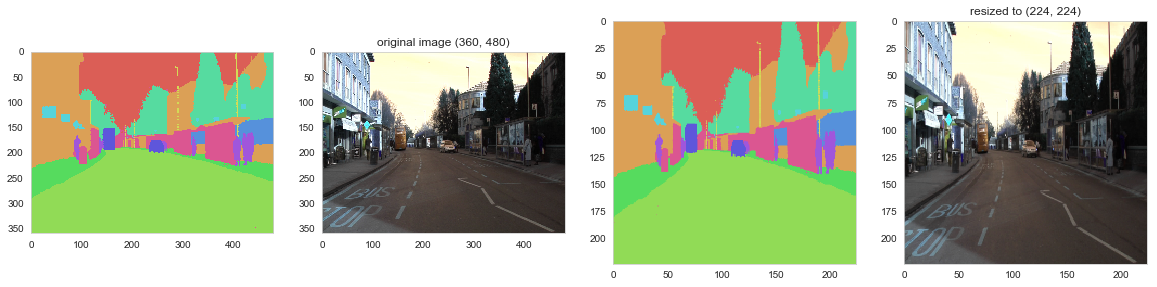

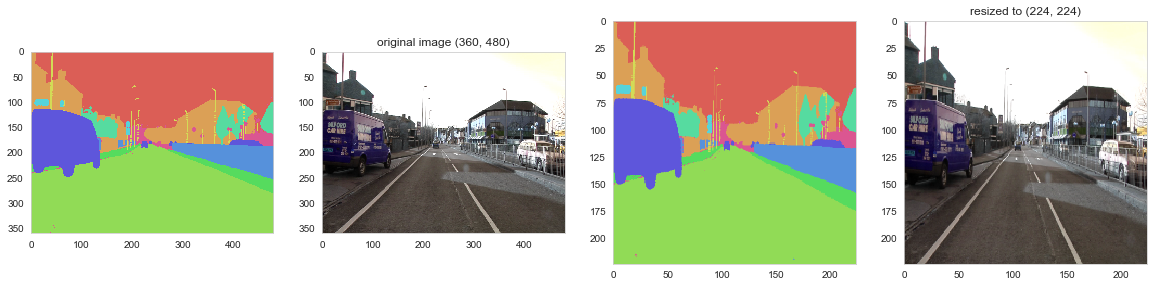

In [19]:
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm=fnm.split('.')[0]
    seg=cv2.imread(dir_seg+fnm+'.png')
    img_is=cv2.imread(dir_img+fnm+'.png')
    seg_img=give_color_to_seg_img(seg,n_classes)
    
    fig=plt.figure(figsize=(20,40))
    ax=fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax=fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax=fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height,input_width)))
    
    ax=fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height,output_width))/255.)
    ax.set_title("resized to {}".format((output_height,output_width)))
    plt.show()

In [20]:
def getImageArr(path,width,height):
    img=cv2.imread(path,1)
    img=np.float32(cv2.resize(img,(width,height)))/127.5-1
    return img

In [21]:
def getSegmentationArr(path,nClasses,width,height):
    seg_labels=np.zeros((height,width,nClasses))
    img=cv2.imread(path,1)
    img=cv2.resize(img,(width,height))
    img=img[:,:,0]
    
    for c in range(nClasses):
        seg_labels[:,:,c]=(img==c).astype(int)
    return seg_labels

In [22]:
images=os.listdir(dir_img)

In [23]:
images.sort()

In [24]:
segmentations=os.listdir(dir_seg)

In [25]:
segmentations.sort()

In [26]:
X=[]
Y=[]

In [27]:
for im,seg in zip(images,segmentations):
    X.append(getImageArr(dir_img+im,input_width,input_height))
    Y.append(getSegmentationArr(dir_seg+seg,n_classes,output_width,output_height))
    
X,Y=np.array(X),np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [29]:
Y[0][:,:,0].shape

(224, 224)

In [35]:
from keras.models import Model,Input
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,GlobalAveragePooling2D,Conv2D,Conv2DTranspose,Add

In [31]:
base_model=VGG19(include_top=False,weights='imagenet',input_shape=(input_height,input_width,3))

In [34]:
base_model.get_layer('block4_pool').output

<tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>

In [39]:
def FCN8(nClasses,input_height,input_width):
    assert input_height%32==0
    assert input_width%32==0
    img_input=Input(shape=(input_height,input_width,3))
    base_model=VGG19(include_top=False,weights='imagenet',input_tensor=img_input)
    x_pool5=base_model.output
    x_pool5=Conv2D(4096,(7,7),activation='relu',padding='same')(x_pool5)
    x_pool5=Conv2D(4096,(1,1),activation='relu',padding='same')(x_pool5)
    x_pool5=Conv2DTranspose(nClasses,kernel_size=(4,4),strides=(4,4),use_bias=False)(x_pool5)
    
    x_pool4=Conv2D(nClasses,(1,1),activation='relu',padding='same')(base_model.get_layer('block4_pool').output)
    x_pool4=Conv2DTranspose(nClasses,kernel_size=(2,2),strides=(2,2),use_bias=False)(x_pool4)
    
    x_pool3=Conv2D(nClasses,(1,1),activation='relu',padding='same')(base_model.get_layer('block3_pool').output)
    
    x=Add()([x_pool5,x_pool4,x_pool3])
    x=Conv2DTranspose(nClasses,kernel_size=(8,8),strides=(8,8),use_bias=False)(x)
    
    model=Model(inputs=img_input,outputs=x)
    return model

In [40]:
model=FCN8(n_classes,224,224)

In [41]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [42]:
from sklearn.utils import shuffle

In [53]:
train_rate=0.85
index_train=np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_valid=list(set(range(X.shape[0]))-set(index_train))

X,y=shuffle(X,Y)
X_train,y_train=X[index_train],Y[index_train]
X_valid,y_valid=X[index_valid],Y[index_valid]
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
del X,Y

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [58]:
from keras import optimizers

In [60]:
sgd=optimizers.SGD(lr=1e-2,decay=5**(-4),momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,
             metrics=['accuracy'])
hist1 = model.fit(X_train,y_train,
                  validation_data=(X_valid,y_valid),
                  batch_size=32,epochs=200,verbose=2)

Train on 311 samples, validate on 56 samples
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_1/SGD/Variable_32/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/SGD/Variable_32, training_1/SGD/Const_32)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_1/SGD/Variable_32/Assign', defined at:
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-1e8dfad653f2>", line 6, in <module>
    batch_size=16,epochs=200,verbose=2)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\engine\training.py", line 1575, in fit
    self._make_train_function()
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\engine\training.py", line 960, in _make_train_function
    loss=self.total_loss)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\optimizers.py", line 165, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\optimizers.py", line 165, in <listcomp>
    moments = [K.zeros(shape) for shape in shapes]
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\backend\tensorflow_backend.py", line 626, in zeros
    dtype, name)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\keras\backend\tensorflow_backend.py", line 316, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\ops\variables.py", line 235, in __init__
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\ops\variables.py", line 387, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\ops\state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 59, in assign
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\Faster-RCNN-TensorFlow-Python3.5-master\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_1/SGD/Variable_32/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/SGD/Variable_32, training_1/SGD/Const_32)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

